In [1]:
# Baseline: 
# zScore Normalization
# 4 blocks (2, 2, 3, 3)
# ReLU, He
# Adam _ lr=1e-3

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader 
from torch.optim import Adam
import torchvision

torch.manual_seed(1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [2]:
batch_size = 256
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4821, 0.4465],
                         std=[0.2471, 0.2435, 0.2616]),
    transforms.RandomErasing(p=0.75,
                             scale=(0.01, 0.3),
                             ratio=(1.0, 1.0),
                             value=0,
                             inplace =True)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4821, 0.4465],
                         std=[0.2471, 0.2435, 0.2616])
])

train_set = CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=train_transform
)

val_set = CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=test_transform
)

trainloader = DataLoader(
    train_set, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=10
)

testloader = DataLoader(
    val_set, 
    batch_size=batch_size,
    shuffle=False, 
    num_workers=10
)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [3]:
class CNNModel(nn.Module):
    def __init__(self, n_classes=10, dropout_rate=0.3):
        super(CNNModel, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 128, 3, stride=1, padding='same'),            
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout_rate)  # Dropout after layer 2
        )
        self.skip1 = nn.Sequential(
            nn.Conv2d(3, 128, 3, stride=2, padding=1),            
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        
        
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.conv_layer4 = nn.Sequential(
            nn.Conv2d(256, 256, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout_rate)  # Dropout after layer 4
        )
        self.skip2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=2, padding=1),            
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )

        

        self.conv_layer5 = nn.Sequential(
            nn.Conv2d(256, 512, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.conv_layer6 = nn.Sequential(
            nn.Conv2d(512, 512, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )
        self.conv_layer7 = nn.Sequential(
            nn.Conv2d(512, 512, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout_rate)  # Dropout after layer 7
        )
        self.skip3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, stride=2, padding=1),            
            nn.ReLU(),
            nn.BatchNorm2d(512)
        )

        

        self.conv_layer8 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(1024)
        )
        self.conv_layer9 = nn.Sequential(
            nn.Conv2d(1024, 1024, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(1024)
        )
        self.conv_layer10 = nn.Sequential(
            nn.Conv2d(1024, 1024, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout_rate)  # Dropout after layer 10
        )
        self.skip4 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, stride=2, padding=1),            
            nn.ReLU(),
            nn.BatchNorm2d(1024)
        )

        

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*2*2, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, n_classes)
        )
    
    def forward(self, x):
        skip = self.skip1(x)
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = x + skip

        skip = self.skip2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = x + skip

        skip = self.skip3(x)
        x = self.conv_layer5(x)
        x = self.conv_layer6(x)
        x = self.conv_layer7(x)
        x = x + skip

        skip = self.skip4(x)
        x = self.conv_layer8(x)
        x = self.conv_layer9(x)
        x = self.conv_layer10(x)
        x = x + skip
        
        out = self.classifier(x)

        return out

In [4]:
model = CNNModel(10)
model.to(device)
print(model)

CNNModel(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (skip1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer4): Se

# Train

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)  
decayRate = 0.96
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [6]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [7]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 250

In [8]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()  
    
        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()


    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # update learning rate
    lr_scheduler.step()

Epoch [1/250], Loss: 1.5574, Accuracy: 43.06%, Test Loss: 1.2511, Test Accuracy: 53.69%
Epoch [2/250], Loss: 1.1407, Accuracy: 58.93%, Test Loss: 1.0426, Test Accuracy: 64.14%
Epoch [3/250], Loss: 0.9484, Accuracy: 66.55%, Test Loss: 0.7279, Test Accuracy: 74.81%
Epoch [4/250], Loss: 0.8236, Accuracy: 71.36%, Test Loss: 0.7126, Test Accuracy: 75.83%
Epoch [5/250], Loss: 0.7551, Accuracy: 73.94%, Test Loss: 0.6085, Test Accuracy: 78.94%
Epoch [6/250], Loss: 0.6973, Accuracy: 75.78%, Test Loss: 0.5515, Test Accuracy: 80.83%
Epoch [7/250], Loss: 0.6583, Accuracy: 77.32%, Test Loss: 0.5091, Test Accuracy: 82.64%
Epoch [8/250], Loss: 0.6133, Accuracy: 78.81%, Test Loss: 0.4855, Test Accuracy: 83.54%
Epoch [9/250], Loss: 0.5835, Accuracy: 79.99%, Test Loss: 0.4638, Test Accuracy: 84.51%
Epoch [10/250], Loss: 0.5650, Accuracy: 80.47%, Test Loss: 0.4744, Test Accuracy: 84.62%
Epoch [11/250], Loss: 0.5398, Accuracy: 81.51%, Test Loss: 0.3995, Test Accuracy: 86.50%
Epoch [12/250], Loss: 0.5116, 

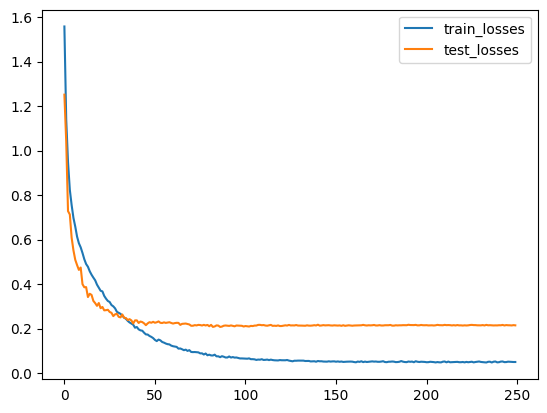

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

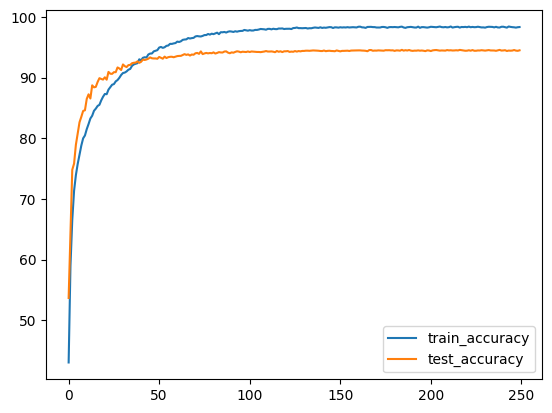

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()

In [11]:
import matplotlib.pyplot as plt
%matplotlib qt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

In [12]:
import matplotlib.pyplot as plt
%matplotlib qt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()